In [1]:
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
# import keract
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau, TensorBoard
# from keras_contrib.callbacks import CyclicLR
from tensorflow.keras.utils import model_to_dot, plot_model
from IPython.display import SVG

In [2]:
train_data_dir = "../input/stanford-dogs-dataset/images/Images/"
img_width, img_height = 224, 224 
channels = 3
batch_size = 64

In [3]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    rotation_range= 20,
    width_shift_range= 0.2,
    height_shift_range= 0.2,   
    validation_split=0.2,

)

valid_datagen = ImageDataGenerator(
    rescale= 1./255, 
    validation_split=0.2,
)

In [4]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='training',
    shuffle= True, 
    seed= 42
) 

valid_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='validation',
    shuffle= True, 
    seed= 42

)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [5]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)
# nb_test_samples = len(test_generator.filenames)

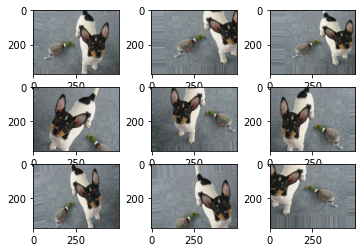

In [6]:
img = load_img('../input/stanford-dogs-dataset/images/Images/n02087046-toy_terrier/n02087046_1004.jpg')
data = img_to_array(img)
samples = expand_dims(data, 0)
it = train_datagen.flow(samples, batch_size=1)

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0]
    plt.imshow(image)

# plt.savefig('augmented_image.png', transparent= True, bbox_inches= 'tight', dpi= 900)
plt.show()

In [7]:
vgg16 = applications.VGG16(include_top= False, input_shape= (img_width, img_height, channels))
vgg16.summary()

58892288/58889256 [==============================] - 1s 0us/step: 
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [25]:
# ResNet50 = applications.ResNet50(include_top= False, input_shape= (img_width, img_height, channels), weights= 'imagenet')
# ResNet50.summary()

94773248/94765736 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
__________________________

In [8]:
model = Sequential()

for layer in vgg16.layers:
    model.add(layer)

for layer in model.layers:
    layer.trainable= False

model.add(Flatten(input_shape= (7, 7, 512)))

model.add(Dense(1024, activation= 'relu', name= 'FC1'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(1024, activation= 'relu', name= 'FC2'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(120, activation= 'softmax', name= 'FC3'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f406f1dcfd0> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f40a476f510> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f406f1fdd10> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f4078efd090> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f406f6a7c50> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f406f6a7150> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f407438f310> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f407431cc10> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f4074320d10> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f406df3f990> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f406df3fa50> False
<tensorflow.python.keras.laye

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
Total params: 23,833,592
Trainable params: 245,880
Non-trainable params: 23,587,712
_________________________________________________________________


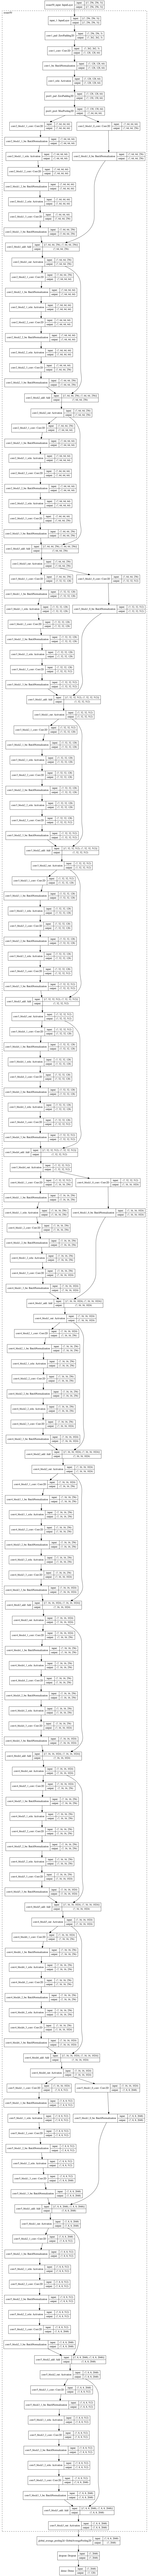

In [26]:
# model = Sequential()

# for layer in ResNet50.layers:
#     layer.trainable= False
#     print(layer,layer.trainable)
    
# model.add(ResNet50)
# model.add(GlobalAveragePooling2D())
# model.add(Dropout(0.5))
# model.add(Dense(120,activation='softmax'))
# model.summary()

# SVG(model_to_dot(model).create(prog='dot', format='svg'))
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [10]:
checkpoint = ModelCheckpoint(
    'baseline_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size= batch_size,
    write_graph= True,
    write_grads= True,
    write_images= False,
)

callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

In [11]:
model.compile(optimizer= keras.optimizers.Adam(lr= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
history = model.fit(
    train_generator, 
    epochs= 15,
    steps_per_epoch = nb_train_samples//batch_size, 
    validation_data = valid_generator, 
    validation_steps = nb_valid_samples//batch_size,
    verbose = 2, 
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/15

Epoch 00001: val_loss improved from inf to 4.19903, saving model to baseline_model.h5
257/257 - 302s - loss: 5.4234 - accuracy: 0.0315 - val_loss: 4.1990 - val_accuracy: 0.0960
Epoch 2/15

Epoch 00002: val_loss improved from 4.19903 to 3.62958, saving model to baseline_model.h5
257/257 - 260s - loss: 4.6007 - accuracy: 0.0726 - val_loss: 3.6296 - val_accuracy: 0.1741
Epoch 3/15

Epoch 00003: val_loss improved from 3.62958 to 3.31282, saving model to baseline_model.h5
257/257 - 259s - loss: 4.1818 - accuracy: 0.1135 - val_loss: 3.3128 - val_accuracy: 0.2163
Epoch 4/15

Epoch 00004: val_loss improved from 3.31282 to 3.15108, saving model to baseline_model.h5
257/257 - 259s - loss: 3.8929 - accuracy: 0.1407 - val_loss: 3.1511 - val_accuracy: 0.2289
Epoch 5/15
